#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import bvcopula
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

animal = 'ST263'
day_name = 'Day4'
path = '/home/nina/VRData/Processing/pkls'

with open("{}/{}_{}_signals.pkl".format(path,animal,day_name),'rb') as f:
    signal_pkl = pkl.load(f)
with open("{}/{}_{}_behaviour.pkl".format(path,animal,day_name),'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['ROIsN','trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))

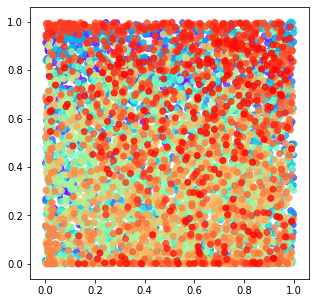

In [3]:
signals = signal_pkl['signals_transformed']
n1 = 6
n2 = 6
#Y_all = np.array([signals[n1],signals[n2]]).T
name1, name2 = 'Velocity', 'Neuron 6'
Y_all = np.array([behaviour_pkl['transformed_velocity'],signals[n1]]).T
X_all = np.array(behaviour_pkl['position'])#local_time
ve = np.array(behaviour_pkl['velocity'])

rule = (Y_all[:,0]>1e-4) & (Y_all[:,1]>1e-4)  \
        & (Y_all[:,0]<1.-1e-4) & (Y_all[:,1]<1.-1e-4)
    
ve = ve[rule]
trials = behaviour_pkl['trials'][rule]
 
X = np.reshape(X_all[rule],(-1,1))
X[X<0] = 160.+X[X<0]
X[X>160] = X[X>160]-160.
X = X/160.
Y = Y_all[rule]

NSamp = X.shape[0]
plt.figure(figsize=(5,5))
colors = cm.rainbow(np.linspace(0., 1., NSamp))
skip = 3
plt.scatter(*Y[::skip].T, color=colors[::skip], alpha=0.8)

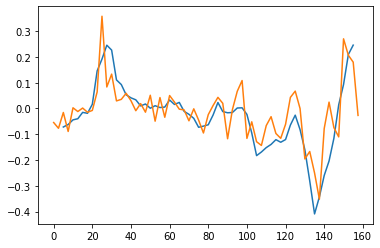

In [4]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau

x,p,k = [],[],[]

X_pos = X.squeeze()*160
Y_pos = Y#norm.ppf(Y)

for b in range(int(160/2.5)):
    dat = Y_pos[(X_pos>b*2.5) & (X_pos<(b+1)*2.5)]
    p.append(pearsonr(*dat.T)[0])
    k.append(kendalltau(*dat.T)[0])
    x.append((b+0)*2.5)
    
p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    
    
plt.plot(x[2:-1],p)
plt.plot(x,k)

x=x[2:-1]

In [5]:
trial_weights = np.zeros_like(trials)
for i, v in enumerate(trials):
    trial_weights[i] = (len(trials)/trials[-1])*1./np.count_nonzero(trials==v)

In [6]:
a = torch.tensor([0,1,2,3])
a[a!=a]

tensor([], dtype=torch.int64)

In [7]:
likelihoods = [#FrankCopula_Likelihood(),
                bvcopula.IndependenceCopula_Likelihood(),
                bvcopula.GaussianCopula_Likelihood(),
                #ClaytonCopula_Likelihood(rotation='180°'),
                #ClaytonCopula_Likelihood(rotation='0°'),
                #GumbelCopula_Likelihood(rotation='0°'),
                ]

In [8]:
NSamp

19082

In [9]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)
weights = torch.tensor(trial_weights).float().cuda(device=0)

In [10]:
# define the model (optionally on GPU)
grid_size = 128
thetas_sharing = torch.tensor([0,0])
if thetas_sharing is not None:
    num_fs = len(likelihoods)+thetas_sharing.max().numpy() # indep_thetas + num_copulas - 1
else:
    num_fs = 2*len(likelihoods)-1
print(num_fs)
model = bvcopula.Mixed_GPInferenceModel(bvcopula.MixtureCopula_Likelihood(likelihoods, theta_sharing=thetas_sharing), 
                               num_fs,  
                               prior_rbf_length=0.5, grid_size=grid_size, grid_bonds=torch.tensor([[0.,1.]])).cuda(device=0)

2


In [11]:
# train the model

torch.autograd.set_detect_anomaly(False)

base_lr = 1e-2
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

#torch.autograd.set_detect_anomaly(True)

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.variational_strategy.variational_distribution.variational_mean},
    #hyperparameters
    {'params': model.covar_module.raw_outputscale, 'lr': .001},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .001} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
            
        loss = -mll(output, train_y) 
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}   length: {}, scale: {}, dLoss: {:.1}, NaNs: {}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                model.covar_module.outputscale.detach().cpu().numpy().squeeze(),
                mean_p, nans
            ))
            if (0 < mean_p < 0.0001):
                print("Converged!")
                break
            p = 0.
            nans = 0

        # The actual optimization step
        loss.backward()
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        # strict
        #assert torch.all(covar_grad==covar_grad)
        #light
        if torch.any(covar_grad!=covar_grad):
            for n, par in model.named_parameters():
                grad = par.grad.data
                nans+=torch.nonzero(grad!=grad).shape[0]
                if torch.any(grad.abs()==float('inf')):
                    print("Grad inf... fixing...")
                    grad = torch.clamp(grad,-1.,1.)
                grad[grad!=grad] = 0.0
                par.grad.data = grad
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: -0.0115   length: [0.4588064  0.48217124], scale: [0.75306034 0.7057842 ], dLoss: 0e+00, NaNs: 0
Iter 200/2000 - Loss: -0.0137   length: [0.43137953 0.45055836], scale: [0.80079323 0.7364301 ], dLoss: 0.005, NaNs: 0
Iter 300/2000 - Loss: -0.015   length: [0.39938554 0.3982905 ], scale: [0.845359  0.8238709], dLoss: 0.0007, NaNs: 0
Iter 400/2000 - Loss: -0.0162   length: [0.35865313 0.3500498 ], scale: [0.89545697 0.9216964 ], dLoss: 0.0006, NaNs: 0
Iter 500/2000 - Loss: -0.0172   length: [0.3144996  0.31194207], scale: [0.9499477 1.0151827], dLoss: 0.0005, NaNs: 0
Iter 600/2000 - Loss: -0.0181   length: [0.27446273 0.28349924], scale: [1.0036904 1.100013 ], dLoss: 0.0005, NaNs: 0
Iter 700/2000 - Loss: -0.0188   length: [0.24396722 0.26270872], scale: [1.0537244 1.1757764], dLoss: 0.0004, NaNs: 0
Iter 800/2000 - Loss: -0.0192   length: [0.2257352  0.24681337], scale: [1.0868517 1.2455677], dLoss: 0.0003, NaNs: 0
Iter 900/2000 -

In [12]:
# print(np.shape(means))
# for i in range(num_fs):
#     plt.plot(means[-1][i])
# losses[losses!=losses] = 0

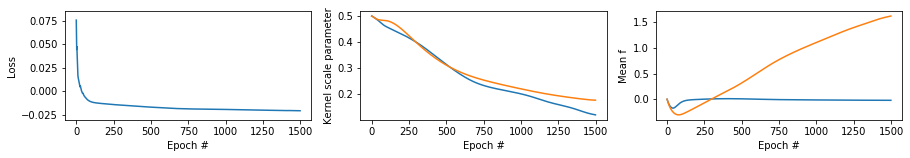

In [13]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
marg = (np.max(losses) - np.min(losses))*0.1
loss.set_ylim(np.min(losses)-marg,
              np.max(losses)+marg)
rbf=np.array(rbf).squeeze()
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x,axis=1) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [14]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

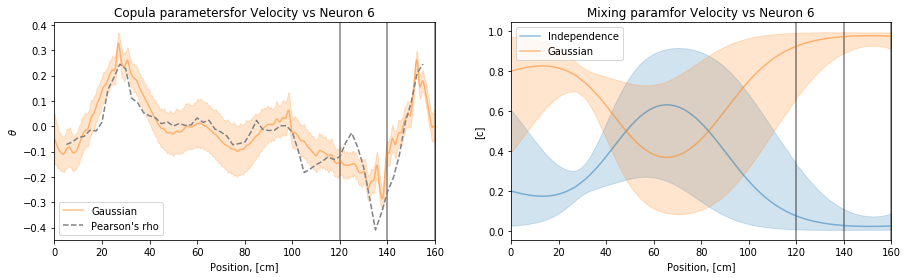

In [15]:
# visualize the result
fig, ax = plt.subplots(1,2,figsize=(15, 4))
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)    
    
utils.Plot_MixModel_Param(ax,model,test_x,testX*160,rho=np.array([x,p]),title='for {} vs {}'.format(name1,name2))

plt.subplots_adjust(hspace=0.5)


In [16]:
WAIC = model.likelihood.WAIC(model(train_x), train_y)
WAIC

tensor(451.1502, device='cuda:0')

In [35]:
n_int = 50
ints = np.linspace(0.,1.,n_int+1)
ent = np.zeros((n_int,2))
for i, (s,e) in enumerate(zip(ints[:-1],ints[1:])):
    ent[i] = [el.cpu().numpy() for el in model.entropy(interv=torch.tensor([s,e]))]

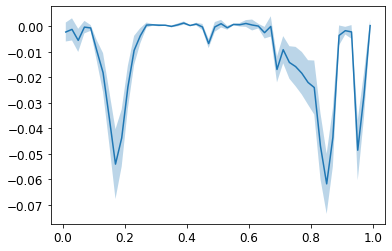

In [36]:
mid = (ints[1:]+ints[:-1])/2
plt.plot(mid,ent[:,0])
plt.fill_between(mid,ent[:,0]-2*ent[:,1],ent[:,0]+2*ent[:,1],alpha=0.3)

In [37]:
model.entropy(sem_tol=1e-3)

(tensor([-0.0135], device='cuda:0'), tensor([0.0010]))

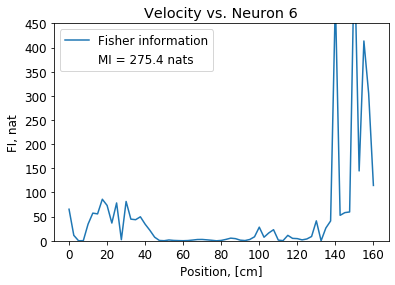

In [18]:
plt.rcParams.update({'font.size': 12})

ds = 2.5
n = int(160/ds)

FI, MI = model.likelihood.input_information(model,train_y,n,160.)

plt.plot(np.arange(n+1)*ds,FI.detach().cpu().numpy(),label='Fisher information')
plt.plot(0,0,color='white',label='MI = {:.1f} nats'.format(MI.detach().cpu().numpy()))
plt.title("{} vs. {}".format(name1,name2))
plt.xlabel('Position, [cm]')
plt.ylabel('FI, nat')
plt.ylim(0,450)
plt.legend()

In [19]:
#generate some samples
model.eval()
with gpytorch.settings.num_likelihood_samples(1):
    gplink = model.likelihood.gplink_function
    copulas = [lik.copula for lik in likelihoods]
    rotations = [lik.rotation for lik in likelihoods]
    thetas, mixes = gplink(model(test_x).mean)
    test_y = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations,theta_sharing=thetas_sharing).rsample()
    Y_sim = test_y.cpu().detach().numpy()

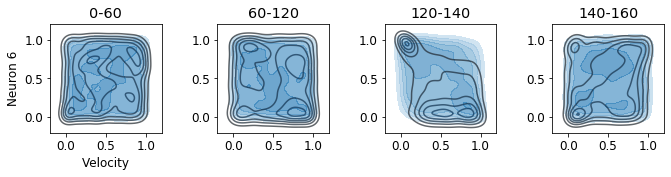

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(11,2))
fig.subplots_adjust(hspace=0.5)

axes[0].set_ylabel(name2)
axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
utils.Plot_Copula_Density(axes, testX.squeeze()*160, Y_sim.squeeze(), interval_ends, shade=True)
utils.Plot_Copula_Density(axes, X.squeeze()*160, Y, interval_ends, shade=False, color='#073763ff')

plt.subplots_adjust(wspace=0.5)